# Code

In [1]:
!pip install pymc3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from matplotlib.patches import Patch
from scipy.integrate import odeint
import pymc3 as pm

Data retrived from refs([1](https://doi.org/10.1038/s41591-021-01377-8), [2](https://www.medrxiv.org/content/10.1101/2021.08.11.21261876v1)) using the web tool [WebPlotDigitalizer](https://apps.automeris.io/wpd/)

In [2]:
df = pd.DataFrame({'Vaccine': ['mRNA-1273', 'NVX-CoV2373', 'BNT162b2', 'rAd26-S + rAd5-S', 'Convalescent',
                               'ChAdOx1 nCoV-19', 'Ad26.COV2.S', 'CoronaVac', 'ChAdOx1 nCoV-19', 'Ad26.COV2.S',
                               'ChAdOx1 nCoV-19', 'BNT162b2', 'ChAdOx1 nCoV-19', 'NVX-CoV2373', 'BNT162b2',
                               'BNT162b2', 'NVX-CoV2373', 'BNT162b2'],
                   'Variant': ['Ancestral', 'Ancestral', 'Ancestral', 'Ancestral', 'Ancestral',
                               'Ancestral', 'Ancestral', 'Ancestral', 'Beta', 'Beta', 'Delta',
                               'Beta', 'Alpha', 'Beta', 'Delta', 'Delta', 'Alpha', 'Alpha'],
                   'Efficacy': [93.5, 95.3, 94.6, 91.2, 88.6, 61.6, 67.2, 50.3, 10.5, 64.2, 60.2, 75.3,
                                66.5, 51.5, 79.6, 88.4, 87.0, 90.2],
                   'Eff 95% up': [96.2, 98.9, 97, 94.6, 97.3, 75.3, 73.8, 61.6, 54.8, 87.3, 77.5, 79.2,
                                  78.3, 76.5, 82.5, 93.6, 94.3, 93.4],
                   'Eff 95% down': [88.7, 67.7, 89.4, 85.1, 65.4, 40.5, 58.9, 35.6, 0.1, 41.4, 29.1, 71.0,
                                    54.5, 0.4, 75.7, 78.8, 72.1, 86.5],
                   'IC_50': [4.16, 4.01, 2.39, 1.41, 1, 0.54, 0.47, 0.17, 0.062, 0.054, 0.14, 0.27,
                             0.33, 0.45, 0.62, 0.62, 2.49, 1.49],
                   'IC_50 up': [10.32, 9.51, 3.81, 2.59, 1.62, 1, 0.81, 0.26, 0.11, 0.094, 0.26, 0.44,
                                0.62, 0.93, 0.98, 0.99, 5.12, 2.37],
                   'IC_50 down': [1.7, 1.96, 1.5, 0.77, 0.62, 0.29, 0.27, 0.11, 0.033, 0.032, 0.076, 0.17,
                                  0.18, 0.22, 0.38, 0.38, 1.21, 0.94]})

For this simple adjustment, I will assume the data behaves as a normal distribution with center at the point estimate and $\sigma$ being the average between upper and lower 95% intervals.

In [3]:
data = df.sort_values('IC_50', inplace=True)

X = np.array(df.loc[:, 'IC_50'])
Y = np.array(df.loc[:, 'Efficacy'])
Y_std = np.array(((df.loc[:, 'Efficacy']-df.loc[:, 'Eff 95% down']) + (df.loc[:, 'Eff 95% up'] - df.loc[:, 'Efficacy']))/4)

N_SAMPLES = 50000

In [4]:
def model_new(x, x_50):
  return 100*x/(x_50 + x)

$$ f(x) = \frac{x}{x_{50} + x} $$

$x_{50}$ is a constant such that

$$ f(x_{50}) = \frac{1}{2} $$

In [5]:
new_model = pm.Model()

with new_model:

    # Priors for unknown model parameters
    alpha = pm.Uniform('alpha', 0, 4)
    #A = pm.Uniform('A', 95, 100)

    # Expected value of outcome
    mu = 100*X/(alpha + X)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, observed=Y, sigma=Y_std)

    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    trace_new = pm.sample(N_SAMPLES, step=step)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Sequential sampling (2 chains in 1 job)
Metropolis: [alpha]


/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


Sampling 2 chains for 1_000 tune and 50_000 draw iterations (2_000 + 100_000 draws total) took 15 seconds.
The number of effective samples is smaller than 25% for some parameters.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


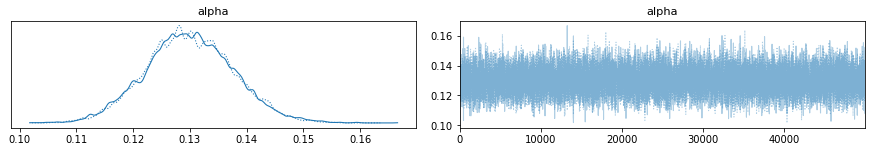

In [6]:
_ = pm.traceplot(trace_new)

In [7]:
# Extract the alpha and beta samples
alpha_samples_new = trace_new["alpha"][10000:, None]

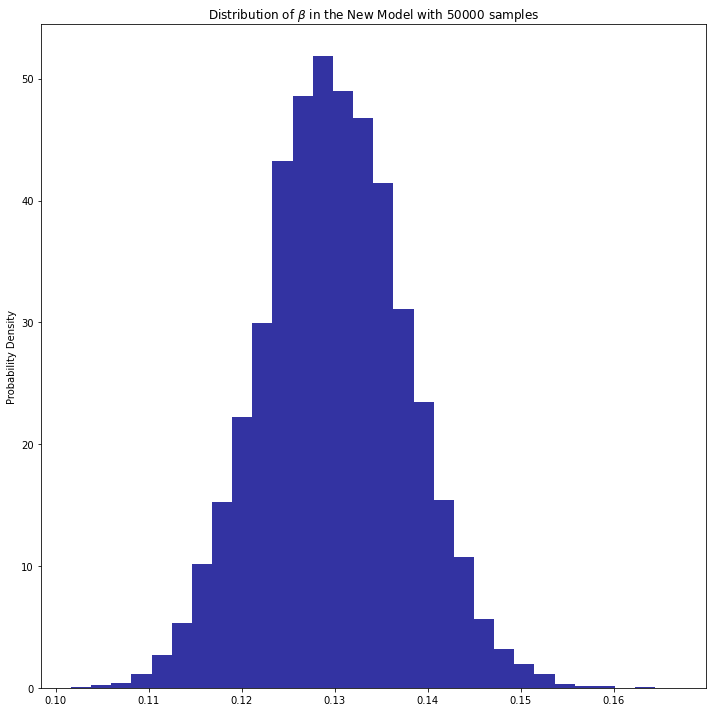

In [8]:
fig,ax = plt.subplots(1,1, figsize=(10,6))

ax.set_title(r"""Distribution of $\beta$ in the New Model with %d samples""" % N_SAMPLES)
ax.hist(alpha_samples_new, histtype='stepfilled', 
         color = 'darkblue', bins=30, alpha=0.8, density=True)
ax.set_ylabel('Probability Density')

plt.tight_layout()

In [9]:
pm.summary(trace_new)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.13,0.008,0.115,0.144,0.0,0.0,13880.0,14212.0,1.0


In [10]:
# nabs values
nabs = np.linspace(0, 15, 10000)[:, None]

# Take most likely parameters to be mean values
alpha_est_new = alpha_samples_new.mean()

new_mod = model_new(nabs, alpha_est_new)

In [11]:
new_alpha_low = pm.summary(trace_new)['hdi_3%']['alpha']
new_alpha_up = pm.summary(trace_new)['hdi_97%']['alpha']

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


In [12]:
print(f"R^2 new model: {r2_score(model_new(df['IC_50'], alpha_est_new), df['Efficacy']):.3f} (95% CI: {r2_score(model_new(df['IC_50'], new_alpha_low), df['Efficacy']):.3f} - {r2_score(model_new(df['IC_50'], new_alpha_up), df['Efficacy']):.3f})")

R^2 new model: 0.576 (95% CI: 0.513 - 0.611)


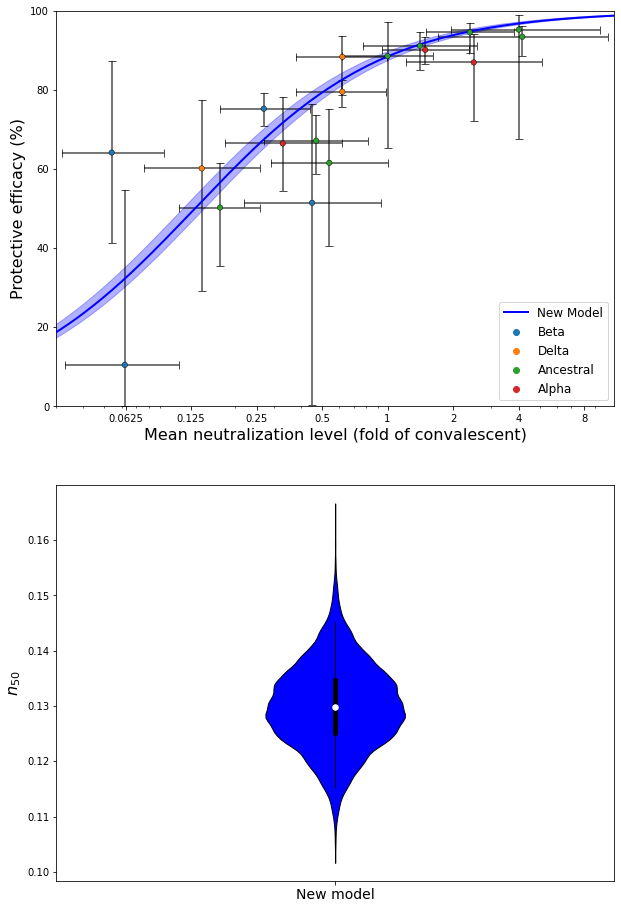

In [13]:
fig, ax = plt.subplots(2,1, figsize=(10,16))
ax[0].errorbar(df['IC_50'], df['Efficacy'], yerr=[df['Efficacy']-df['Eff 95% down'],
                                                df['Eff 95% up']-df['Efficacy']], xerr = [df['IC_50']-df['IC_50 down'],
                                                                                          df['IC_50 up']-df['IC_50']], fmt = 'none',
             color = 'black', capsize = 4, alpha = 0.7)
sns.scatterplot(data = df, x = 'IC_50', y = 'Efficacy', hue = 'Variant', edgecolor = 'black',
            s=30, alpha=1, zorder=5, ax = ax[0])
ax[0].plot(nabs, new_mod, color = 'blue', 
         lw=2, label="New Model", zorder = 4)
ax[0].fill_between(nabs.flatten(), model_new(nabs, new_alpha_low).flatten(), model_new(nabs, new_alpha_up).flatten(),
                 color = 'blue', alpha = 0.3)
ax[0].legend(loc = 'lower right', prop={'size':12})
ax[0].set_ylabel('Protective efficacy (%)', fontsize = 16)
ax[0].set_xlabel('Mean neutralization level (fold of convalescent)', fontsize = 16)
ax[0].set_xscale('log')
ax[0].set_xticks([0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8])
ax[0].set_xticklabels(labels = ['0.0625', '0.125', '0.25', '0.5', '1', '2', '4', '8'])
ax[0].set_xlim(0.03,11)
ax[0].set_ylim(0,100)

parts2 = ax[1].violinplot(alpha_samples_new, showmeans=False, showextrema = False, showmedians=False,
                          positions = [0])
for pc in parts2['bodies']:
    pc.set_facecolor('blue')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
quartile1, medians, quartile3 = np.percentile(alpha_samples_new, [25, 50, 75])
whiskers_min, whiskers_max = np.percentile(alpha_samples_new, [2.5, 97.5])
ax[1].scatter(0, medians, marker='o', color='white', s=30, zorder=3)
ax[1].vlines(0, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax[1].vlines(0, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

ax[1].set_ylabel(r'$n_{50}$', fontsize = 16)
ax[1].set_xticks([0])
ax[1].set_xticklabels(labels=['New model'], fontsize = 14)
ax[1].set_xlim(-1,1)

plt.savefig('Models_vaccines.png', dpi = 300, bbox_inches = 'tight')

In [15]:
model_new(0, alpha_est_new)

0.0

# References

1. Khoury, D. S., Cromer, D., Reynaldi, A., Schlub, T. E., Wheatley, A. K., Juno, J. A., ... & Davenport, M. P. (2021). Neutralizing antibody levels are highly predictive of immune protection from symptomatic SARS-CoV-2 infection. Nature medicine, 1-7. [https://doi.org/10.1038/s41591-021-01377-8](https://doi.org/10.1038/s41591-021-01377-8)

2. Cromer, D., Steain, M., Reynaldi, A., Schlub, T. E., Wheatley, A. K., Juno, J. A., ... & Davenport, M. P. (2021). SARS-CoV-2 variants: levels of neutralisation required for protective immunity. medRxiv. [https://doi.org/10.1101/2021.08.11.21261876](https://doi.org/10.1101/2021.08.11.21261876)